## Stochastic Galerkin for 2D Poisson Equation
Seek solution $u(x,y,\omega)$ that satisfies:
- $\alpha(\omega) (u(x,y,\omega)_{xx} + u(x,y,\omega)_{yy}) = 1$ on $\mathcal{D} \times \Omega$
- $u(x,y,\omega) = 0$ on $\partial \mathcal{D} \times \Omega$

where $\mathcal{D} = \{(x,y): -1 \leq x \leq 1, -1 \leq y \leq 1\}$ is the spatial domain and $\Omega$ is the sample space. Also $\alpha(\omega)$ is a random variable distributed over the interval $[1,3]$.

In [34]:
#Import necessary modules
import numpy as np
from scipy.sparse import diags, csr_matrix, kron
from scipy.linalg import solve_sylvester, schur, expm
from scipy.sparse.linalg import spsolve, cg
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
import random
%config InlineBackend.figure_format = 'svg'

In [148]:
def plot_sol(X,Y,U):
    plt.figure(0)
#     ax = plt.axes(projection='3d')
    xline = np.reshape(X, -1)
    yline = np.reshape(Y, -1)
    zline = np.reshape(U, -1)
#     plt.contourf(X, Y, U)
    plt.imshow(U, extent=[-1,1,-1,1], origin='lower')
    plt.colorbar()
    plt.axis(aspect='image')
    plt.xlabel('x')
    plt.ylabel('y')
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('u')
#     ax.plot3D(xline, yline, zline)

def compute_err(U, U_exact):
    n = len(U)
    err_inf = 0
    err_sq = 0
    for i in range(0,n):
        for j in range(0,n):
            err_sq += np.absolute(U_exact[i][j] - U[i][j])**2
            if np.absolute(U_exact[i][j] - U[i][j]) > err_inf:
                err_inf = np.absolute(U_exact[i][j] - U[i][j])
        
    err_sq = (err_sq * h**2)**0.5
    return err_inf, err_sq


[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


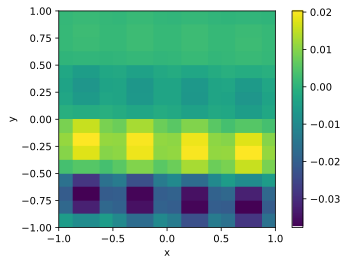

In [168]:
import numpy as np
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve, cg
from scipy.special import legendre
from scipy.integrate import quad
from sympy import *
from scipy import sparse

n = 16 #number of grid points in each spatial direction
h = 1/(n+1) #grid spacing
r = 1 #number of random dimensions
k = 3 #order of PCE
p = int((np.math.factorial(k+r)/np.math.factorial(k)) - 1)

def inner_product(i,j): 
    I = lambda x: (1/2)*legendre(i,x)*(x+2)*legendre(j,x)
    return quad(I,-1,1)[0]
    

#Define central differencing operator matrix using five point stencil 
diagonals = [[-2],[1],[1]]
T = np.multiply((1)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())
L = kron(np.eye(n),T) + kron(T.transpose(),np.eye(n)).todense()

P = np.zeros([p+1,p+1]) #P is (p+1)*(p+1) matrix with P_ij = <psi_i*(xi+2)*psi_j>
for i in range(0,p+1):
    for j in range(0,p+1):
        P[i][j] = inner_product(i,j)
                
        
f = np.zeros([p+1,n**2])
f[0] = 1
print(f)
f = np.reshape(f,((n**2)*(p+1),1))
D = kron(P,L).todense()
U = np.linalg.solve(D, f)
U = np.reshape(U,(n**2,p+1))
print(f)

# mean_sol = U[:,0]
# U = np.reshape(mean_sol,(n,n))

u = np.zeros([n**2,1])
for i in range(0,n**2):
    u[i] = U[i].sum()/len(U[i])
U = np.reshape(u,(n,n))

#Compute exact solution for comparison
U_exact = np.sin(np.pi*X) * np.sin(np.pi*Y)

# a = quad(I,-1,1)[0]
# e = np.ones([n**2])

# U = spsolve(a*L,e)
# D = kron(P,L)

    
#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(-1+h, 1-h, n)
y = np.linspace(-1+h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

plot_sol(X,Y,U)
err_inf, err_sq = compute_err(U,U_exact)
    



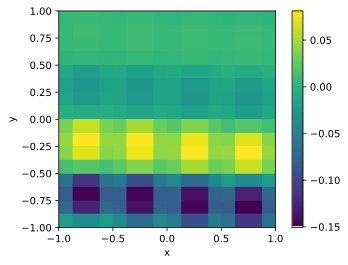

In [255]:
import numpy as np
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve, cg
from scipy.special import legendre
from scipy.integrate import quad
from sympy import *

n = 16 #number of grid points in each spatial direction
h = 1/(n+1) #grid spacing
r = 1 #number of random dimensions
k = 3 #order of PCE
p = int((np.math.factorial(k+r)/np.math.factorial(k)) - 1) #p+1=(k+r)!/k!

def inner_product(i,j): 
    I = lambda xi: (1/2)*legendre(i,xi)*(xi+2)*legendre(j,xi)
    return quad(I,-1,1)[0]
    

#Define central differencing operator matrix using five point stencil 
diagonals = [[-2],[1],[1]]
T = np.multiply((1)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())
L = kron(np.eye(n),T) + kron(T.transpose(),np.eye(n)).todense()

P = np.zeros([p+1,p+1]) #P is (p+1)*(p+1) matrix with P_ij = <psi_i*(xi+2)*psi_j>
for i in range(0,p+1):
    for j in range(0,p+1):
        P[i][j] = inner_product(i,j)
                
e = np.ones([n**2])
f = np.zeros([p+1,n**2])
f[0] = e
f = np.reshape(f,-1)

A = kron(P,L).todense() 
U = np.linalg.solve(A,f)
U = np.reshape(U,(n**2,(p+1)))
u = np.zeros([n**2,1])
for i in range(0,n**2):
    for j in range(0,p+1):
        u[i] += U[i][j]
#     u[i] = u[i]/(p+1)

u = np.reshape(u,(n,n))

#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(-1+h, 1-h, n)
y = np.linspace(-1+h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

plot_sol(X,Y,u)